## Calculating the posterior probability distribution of parameters with **emcee()** python module

**emcee** can be used to obtain the posterior probability distribution of parameters, given a set of experimental data. An example problem is a double exponential decay. A small amount of Gaussian noise is also added.<!-- TEASER_END -->



In [1]:
%matplotlib inline
import numpy as np
import lmfit
from matplotlib import pyplot as plt
import corner
import emcee
from pylab import *
ion()

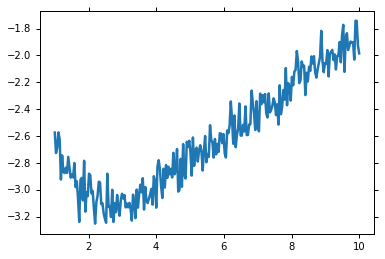

In [2]:
x = np.linspace(1, 10, 250)
np.random.seed(0)
y = 3.0 * np.exp(-x / 2) - 5.0 * np.exp(-(x - 0.1) / 10.) + 0.1 * np.random.randn(len(x))

plt.plot(x, y)

### Initializing our example creating a parameter set for the initial guesses:

In [3]:
p = lmfit.Parameters()
p.add_many(('a1', 4.), ('a2', 4.), ('t1', 3.), ('t2', 3., True))

def residual(p):
    v = p.valuesdict()
    return v['a1'] * np.exp(-x / v['t1']) + v['a2'] * np.exp(-(x - 0.1) / v['t2']) - y


### Solving with minimize() gives the Maximum Likelihood solution.:

[[Variables]]
    a1:   2.98623688 (init= 4)
    a2:  -4.33525596 (init= 4)
    t1:   1.30993185 (init= 3)
    t2:   11.8240752 (init= 3)
[[Correlations]] (unreported correlations are <  0.500)


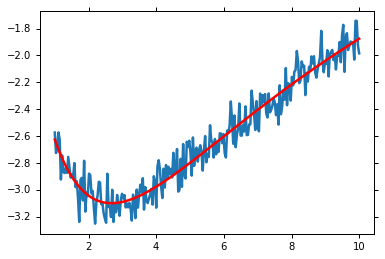

In [4]:
mi = lmfit.minimize(residual, p, method='Nelder')
#mi = lmfit.minimize(residual, p)
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)

plt.plot(x, y)
plt.plot(x, residual(mi.params) + y, 'r')
plt.show()

However, **this doesn’t give a probability distribution** for the parameters. Furthermore, we wish to deal with the data uncertainty. This is called marginalisation of a nuisance parameter. **emcee** requires a function that returns the log-posterior probability. 

### Posterior distribution estimation

The log-posterior probability is a **sum of the log-prior probability and log-likelihood functions**. The log-prior probability is assumed to be zero if all the parameters are within their bounds and -np.inf if any of the parameters are outside their bounds.:

In [65]:
# add a noise parameter
mi.params.add('f', value=1, min=0.001, max=2)

# This is the log-likelihood probability for the sampling. We're going to estimate the
# size of the uncertainties on the data as well.
def lnprob(p):
    resid = residual(p)
    s = p['f']
    resid *= 1 / s
    resid *= resid
    resid += np.log(2 * np.pi * s**2)
    return -0.5 * np.sum(resid)

Lets have a look at those posterior distributions for the parameters.

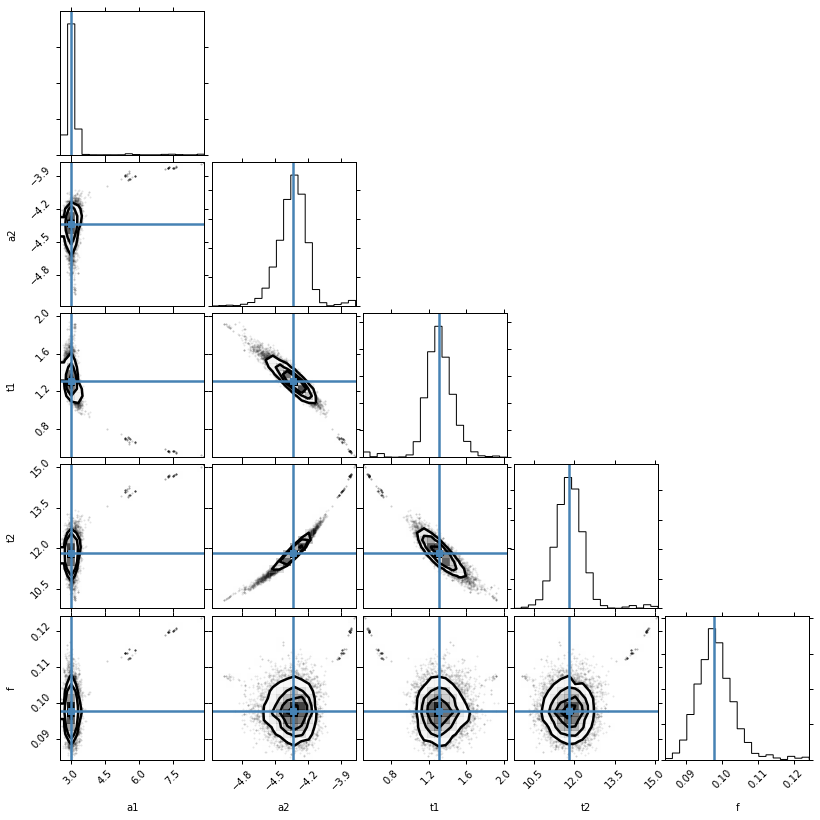

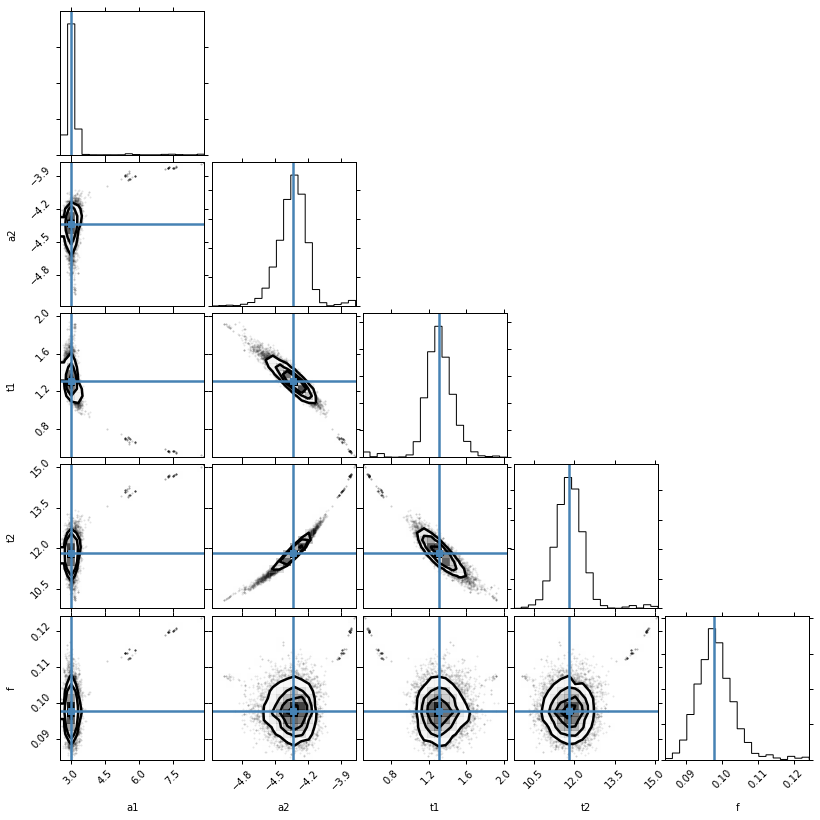

In [66]:
mini = lmfit.Minimizer(lnprob, mi.params)
res = mini.emcee(burn=300, steps=600, thin=3, params=mi.params)
corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()))

**The values reported in the MinimizerResult are the medians of the probability distributions and a 1 sigma quantile**, estimated as half the difference between the 15.8 and 84.2 percentiles. 

The median value is not necessarily the same as the Maximum Likelihood Estimate. We’ll get that as well. You can see that we recovered the right uncertainty level on the data:

In [63]:
lmfit.report_fit(mi.params)
print('---------------------------------------------')
print("median of posterior probability distribution")
print('---------------------------------------------')
lmfit.report_fit(res.params)

[[Variables]]
    a1:   2.98623688 (init= 4)
    a2:  -4.33525596 (init= 4)
    t1:   1.30993185 (init= 3)
    t2:   11.8240752 (init= 3)
    f:    1          (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
---------------------------------------------
median of posterior probability distribution
---------------------------------------------
[[Variables]]
    a1:   3.00335474 +/- 0.149953 (4.99%) (init= 2.986237)
    a2:  -4.34613710 +/- 0.125756 (2.89%) (init=-4.335256)
    t1:   1.32239665 +/- 0.142728 (10.79%) (init= 1.309932)
    t2:   11.7877356 +/- 0.494621 (4.20%) (init= 11.82408)
    f:    0.09745326 +/- 0.004409 (4.52%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(a2, t2)                    =  0.982 
    C(a2, t1)                    = -0.938 
    C(t1, t2)                    = -0.900 
    C(a1, t1)                    = -0.506 
    C(a1, a2)                    =  0.209 
    C(a1, t2)                    =  0.181 


## Let's find the maximum likelihood solution

In [30]:
highest_prob = np.argmax(res.lnprob)
hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
mle_soln = res.chain[hp_loc]
for i, par in enumerate(p):
    p[par].value = mle_soln[i]

print("\nMaximum likelihood Estimation")
print('-----------------------------')
print(p)


Maximum likelihood Estimation
-----------------------------
Parameters([('a1', <Parameter 'a1', 2.9918787362872967, bounds=[-inf:inf]>), ('a2', <Parameter 'a2', -4.3417405805698426, bounds=[-inf:inf]>), ('t1', <Parameter 't1', 1.311063682571598, bounds=[-inf:inf]>), ('t2', <Parameter 't2', 11.799250826701071, bounds=[-inf:inf]>)])


## Finally lets work out a 1 and 2-sigma error estimate for 't1'

In [31]:
quantiles = np.percentile(res.flatchain['t1'], [2.28, 15.9, 50, 84.2, 97.7])
print("2 sigma spread", 0.5 * (quantiles[-1] - quantiles[0]))

('2 sigma spread', 0.30335791366419951)
